### EDA & 결측치 처리 
- 모델 돌릴때 credit_data / investment_data 결측치 제거 필수 
- final_features 에서 결측치 제거 후 credit_data_model / investment_data_model에 반영 
    - 원본 final_features / credit_data_web / investment_data_web는 바뀌면 X 


credit_data 결측치 
- ebitda_to_interest_expense 7
- market_capitalization 39

investment_data 결측치 
- interest_coverage_ratio 7
- earnings_per_share 39
- book_value_per_share 39
- price_earnings_ratio 39
- price_to_book_ratio 39
- price_cash_flow_ratio 39
- enterprise_value_to_ebitda 39
- market_capitalization 39
- accounts_receivable_turnover 12
- inventory_turnover 77
- accounts_payable_turnover 10 




In [19]:
import pymysql
import pandas as pd
import numpy as np
import warnings
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", category=FutureWarning)

username = "*****!"
password = "*****!"
hostname = "ec2-15-152-211-160.ap-northeast-3.compute.amazonaws.com"
database_name = "Data_Warehouse"

cnx = pymysql.connect(
    user=username,
    password=password,
    host=hostname,
    database=database_name,
)

query = "SELECT * FROM Data_Warehouse.final_features;"
data = pd.read_sql(query, cnx)
cnx.close()

/var/folders/_r/qrlg6jnd1l5b_xdkq486q0zr0000gn/T/ipykernel_16005/822524164.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, cnx)


### 원본 credit_data / investment_data 확인 

In [20]:
credit_data = data[["corp", "stock_code", "sector", "year"]].copy()

data.loc[:, "net_borrowings"] = data["borrowings"] - data["cash_and_equivalents"]
data.loc[:, "quick_assets"] = data["current_assets"] - data["inventory"]

credit_data.loc[:, "ebitda_margin"] = data["ebitda"] / data["revenue"] * 100
credit_data.loc[:, "ebitda_to_interest_expense"] = data["ebitda"] / data["interest"]
credit_data.loc[:, "debt_ratio"] = data["total_liabilities"] / data["total_assets"]
credit_data.loc[:, "dependence_on_net_borrowings"] = (
    data["borrowings"] / data["total_equity"]
)

credit_data.loc[:, "net_borrowings_to_ebitda"] = data["net_borrowings"] / data["ebitda"]
credit_data.loc[:, "sales_revenue"] = data["revenue"]
credit_data.loc[:, "cogs"] = data["cost_of_sales"]
credit_data.loc[:, "selling_general_administrative_expenses"] = data[
    "selling_general_administrative_expenses"
]
credit_data.loc[:, "ebit"] = data["ebit"]
credit_data.loc[:, "ebit_margin"] = data["ebit"] / data["revenue"] * 100
credit_data.loc[:, "ebitda_to_sales_revenue"] = data["ebitda"] / data["revenue"]
credit_data.loc[:, "total_assets"] = data["total_assets"]
credit_data.loc[:, "roa"] = data["net_income"] / data["total_assets"] * 100
credit_data.loc[:, "ebitda"] = data["ebitda"]
credit_data.loc[:, "financial_expenses"] = data["interest"]
credit_data.loc[:, "corporate_tax"] = data["tax"]
credit_data.loc[:, "operating_cash_flow"] = data["cash_flow_operating"]
credit_data.loc[:, "free_cash_flow"] = (
    data["cash_flow_operating"] - data["cash_flow_investing"]
)
credit_data.loc[:, "total_liabilities"] = data["total_liabilities"]
credit_data.loc[:, "total_equity"] = data["total_equity"]
credit_data.loc[:, "total_borrowings"] = data["borrowings"]
credit_data.loc[:, "net_borrowings"] = data["net_borrowings"]
credit_data.loc[:, "borrowing_dependency"] = data["borrowings"] / data["total_equity"]
credit_data.loc[:, "total_borrowings_to_ebitda"] = data["borrowings"] / data["ebitda"]
credit_data.loc[:, "debt_to_net_income_ratio"] = (
    data["total_liabilities"] / data["net_income"]
)
credit_data.loc[:, "total_assets_leverage"] = (
    data["total_assets"] / data["total_equity"]
)
credit_data.loc[:, "current_liabilities"] = data["current_liabilities"]
credit_data.loc[:, "working_capital"] = (
    data["current_assets"] - data["current_liabilities"]
)
credit_data.loc[:, "current_liabilities_ratio"] = (
    data["current_liabilities"] / data["current_assets"]
)
credit_data.loc[:, "quick_assets"] = data["quick_assets"]
credit_data.loc[:, "quick_ratio"] = data["quick_assets"] / data["current_liabilities"]
credit_data.loc[:, "cash_and_cash_equivalents"] = data["cash_and_equivalents"]
credit_data.loc[:, "short_term_borrowings"] = data["short_borrowing"]
credit_data.loc[:, "days_sales_outstanding"] = (
    data["accounts_receivable"] / data["revenue"] * 365
)
credit_data.loc[:, "average_accounts_receivable_per_sales_turnover"] = (
    data["accounts_receivable"] / data["revenue"]
)
credit_data.loc[:, "market_capitalization"] = data["market_capitalization"]

credit_data = credit_data.replace([np.inf, -np.inf], np.nan)

In [21]:
investment_data = data[["corp", "stock_code", "sector", "year"]].copy()

data["earnings_per_share"] = data["net_income"] / data["outstanding_shares"]
data["book_value_per_share"] = data["total_equity"] / data["outstanding_shares"]


# 수익성 (Profitability)
investment_data["gross_profit_margin"] = (data["gross_profit"] / data["revenue"]) * 100
investment_data["operating_profit_margin"] = (
    data["operating_income"] / data["revenue"]
) * 100
investment_data["net_profit_margin"] = (data["net_income"] / data["revenue"]) * 100
investment_data["ebitda_margin"] = (data["ebitda"] / data["revenue"]) * 100
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["return_on_assets"] = (data["net_income"] / data["total_assets"]) * 100
investment_data["return_on_invested_capital"] = data["operating_income"] / (
    data["total_equity"] + data["total_liabilities"]
)

# 안정성 (Stability)
investment_data["debt_ratio"] = data["total_liabilities"] / data["total_assets"]
investment_data["current_ratio"] = data["current_assets"] / data["current_liabilities"]
investment_data["quick_ratio"] = (data["current_assets"] - data["inventory"]) / data[
    "current_liabilities"
]
investment_data["non_current_debt_ratio"] = (
    data["non_current_liabilities"] / data["total_assets"]
)
investment_data["equity_ratio"] = data["total_equity"] / data["total_assets"]
investment_data["interest_coverage_ratio"] = data["ebit"] / data["interest"]
investment_data["debt_to_equity_ratio"] = (
    data["total_liabilities"] / data["total_equity"]
)
investment_data["net_debt_ratio"] = (
    data["borrowings"] - data["cash_and_equivalents"]
) / data["total_assets"]
investment_data["retention_ratio"] = data["retained_earnings"] / data["net_income"]


# 가치지표 (Valuation Ratios)
investment_data["earnings_per_share"] = data["net_income"] / data["outstanding_shares"]
investment_data["book_value_per_share"] = (
    data["total_equity"] / data["outstanding_shares"]
)
investment_data["price_earnings_ratio"] = (
    data["stock_price"] / data["earnings_per_share"]
)
investment_data["price_to_book_ratio"] = (
    data["stock_price"] / data["book_value_per_share"]
)
investment_data["price_cash_flow_ratio"] = data["stock_price"] / (
    data["cash_flow_operating"] / data["outstanding_shares"]
)
investment_data["enterprise_value_to_ebitda"] = (
    data["market_capitalization"] + data["borrowings"] - data["cash_and_equivalents"]
) / data["ebitda"]

investment_data["market_capitalization"] = data["market_capitalization"]


# 성장성 (Growth): 성장성 대신 성장성에 해당하는 계정 넣어도 성장성이 반영 됨 
investment_data['revenue'] = data['revenue']
investment_data['operating_income'] = data['operating_income']
investment_data['net_income'] = data['net_income']
investment_data['total_assets'] = data['total_assets']
investment_data['fixed_assets'] = data['fixed_assets']
investment_data['total_liabilities'] = data['total_liabilities']
investment_data['total_equity'] = data['total_equity']


# 활동성 (Efficiency)
investment_data["total_asset_turnover"] = data["revenue"] / data["total_assets"]
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["net_working_capital_turnover"] = data["revenue"] / (
    data["current_assets"] - data["current_liabilities"]
)
investment_data["fixed_asset_turnover"] = data["revenue"] / data["fixed_assets"]
investment_data["accounts_receivable_turnover"] = (
    data["revenue"] / data["accounts_receivable"]
)
investment_data["inventory_turnover"] = data["cost_of_sales"] / data["inventory"]
investment_data["accounts_payable_turnover"] = (
    data["cost_of_sales"] / data["accounts_payable"]
)

investment_data = investment_data.replace([np.inf, -np.inf], np.nan)

In [22]:
print(credit_data.isna().sum())
print(investment_data.isna().sum()) 

corp                                               0
stock_code                                         0
sector                                             0
year                                               0
ebitda_margin                                      0
ebitda_to_interest_expense                         7
debt_ratio                                         0
dependence_on_net_borrowings                       0
net_borrowings_to_ebitda                           0
sales_revenue                                      0
cogs                                               0
selling_general_administrative_expenses            0
ebit                                               0
ebit_margin                                        0
ebitda_to_sales_revenue                            0
total_assets                                       0
roa                                                0
ebitda                                             0
financial_expenses                            

NULL DATA FOR CREDIT_DATA


ebitda_to_interest_expense

count     3097.000000
mean        40.948553
std        760.817358
min      -1312.671136
25%         -0.050986
50%          2.227229
75%          8.040380
max      37330.000000
Name: ebitda_to_interest_expense, dtype: float64


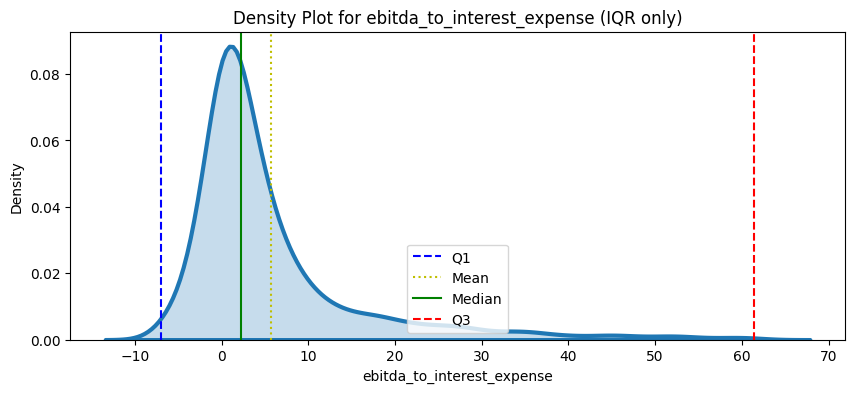

market_capitalization

count    3.065000e+03
mean     2.760645e+12
std      2.308866e+13
min      0.000000e+00
25%      1.142460e+11
50%      2.751000e+11
75%      9.604862e+11
max      8.918334e+14
Name: market_capitalization, dtype: float64


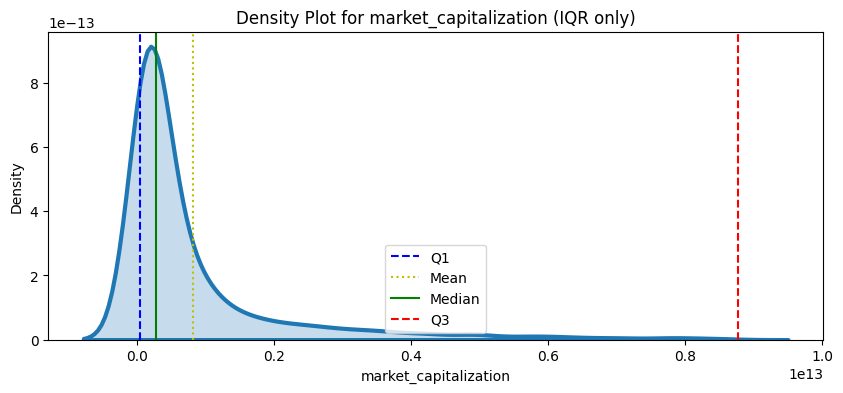

NULL DATA FOR INVESTMENT_DATA


interest_coverage_ratio

count     3097.000000
mean        40.615617
std        754.588118
min      -1312.671136
25%         -0.057249
50%          2.217798
75%          7.907760
max      37021.250000
Name: interest_coverage_ratio, dtype: float64


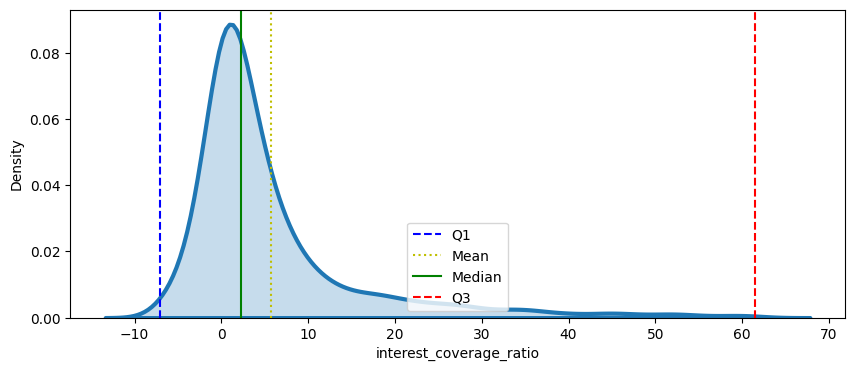

earnings_per_share

count      3065.000000
mean       3786.537393
std       15621.542754
min     -128166.342192
25%         -12.548881
50%         619.981856
75%        3388.195017
max      307373.863237
Name: earnings_per_share, dtype: float64


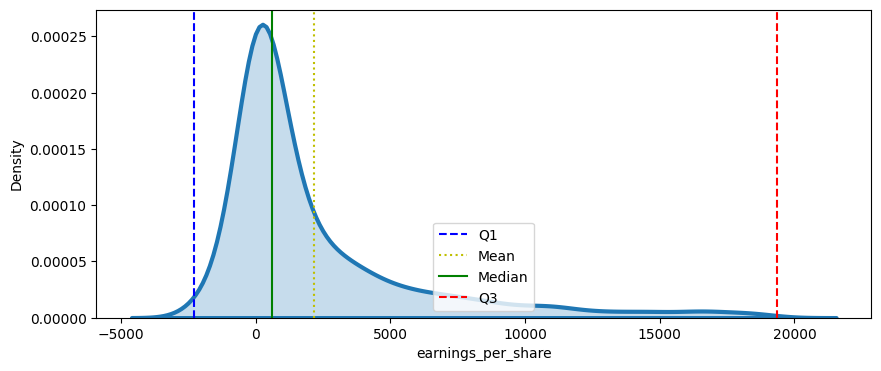

book_value_per_share

count    3.065000e+03
mean     6.578448e+04
std      1.901882e+05
min     -6.677692e+03
25%      5.263218e+03
50%      1.513890e+04
75%      5.636778e+04
max      3.779253e+06
Name: book_value_per_share, dtype: float64


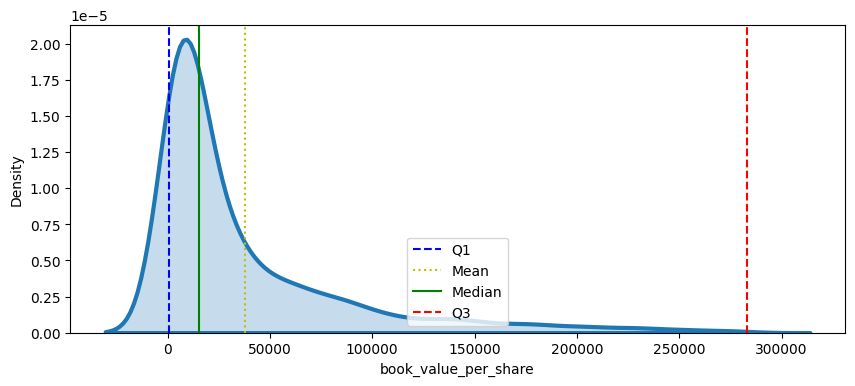

price_earnings_ratio

count      3065.000000
mean        172.164342
std        7688.253676
min      -15762.066526
25%          -1.122671
50%           7.577958
75%          17.515441
max      419797.678852
Name: price_earnings_ratio, dtype: float64


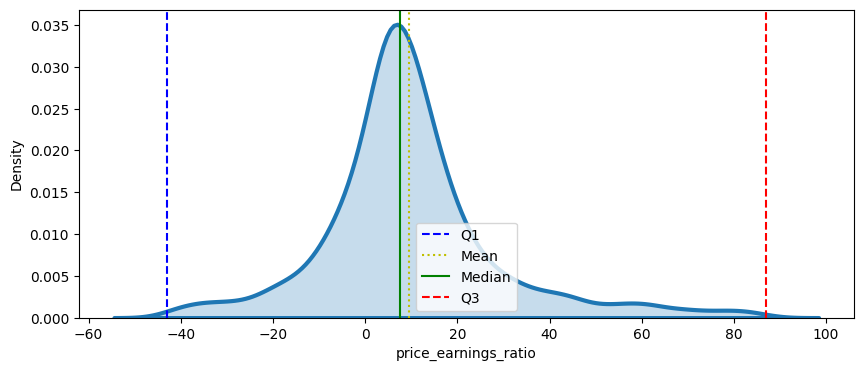

price_to_book_ratio

count    3065.000000
mean        8.695436
std       146.597401
min     -1251.321964
25%         0.437329
50%         0.748253
75%         1.486892
max      4834.020619
Name: price_to_book_ratio, dtype: float64


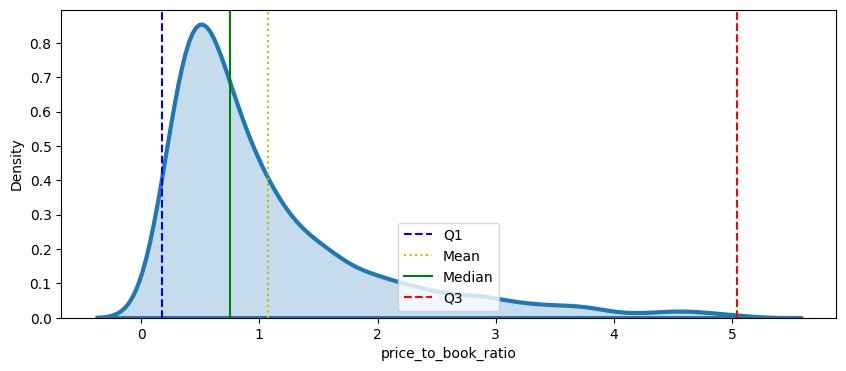

price_cash_flow_ratio

count      3065.000000
mean         54.754673
std        2492.905396
min      -51315.026128
25%           1.034362
50%           4.811056
75%          11.842602
max      102046.568082
Name: price_cash_flow_ratio, dtype: float64


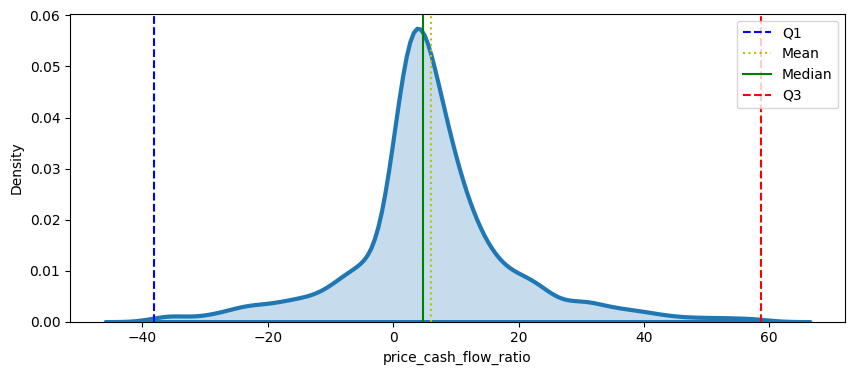

enterprise_value_to_ebitda

count      3065.000000
mean        130.693973
std        6101.757094
min      -23056.691534
25%          -0.069500
50%           7.198402
75%          17.227713
max      329567.545659
Name: enterprise_value_to_ebitda, dtype: float64


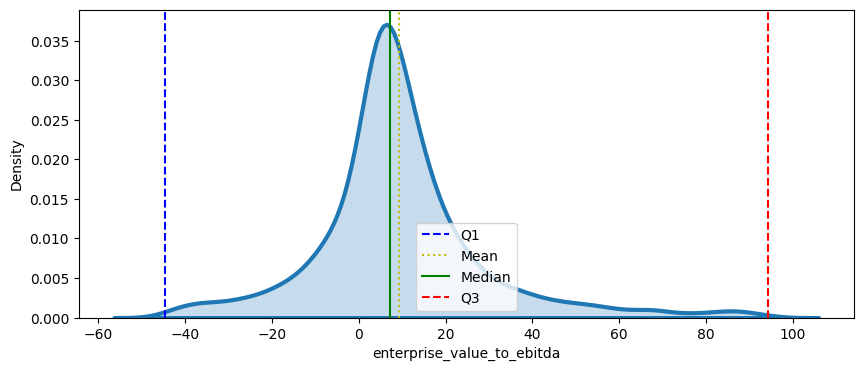

accounts_receivable_turnover

count     3092.000000
mean        22.344395
std        380.242677
min          0.168414
25%          4.849910
50%          6.547619
75%          9.107191
max      18135.464558
Name: accounts_receivable_turnover, dtype: float64


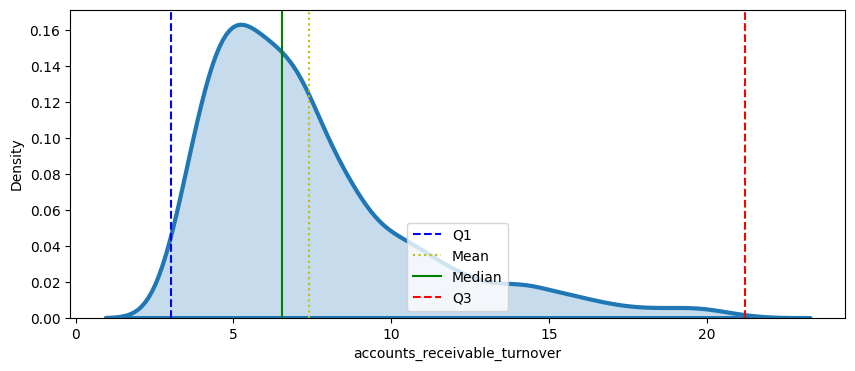

inventory_turnover

count     3027.000000
mean       176.328663
std       2925.941734
min          0.000000
25%          3.417271
50%          5.828694
75%         10.438142
max      84333.139443
Name: inventory_turnover, dtype: float64


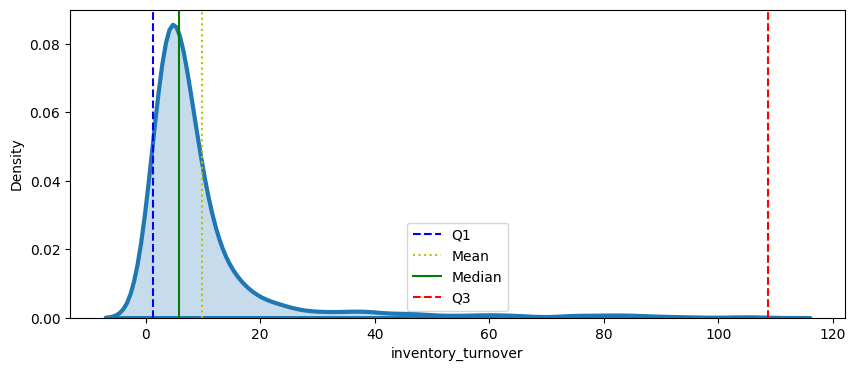

accounts_payable_turnover

count     3094.000000
mean        95.656487
std       2267.295785
min          0.000000
25%          4.991792
50%          7.366614
75%         10.883664
max      82615.462270
Name: accounts_payable_turnover, dtype: float64


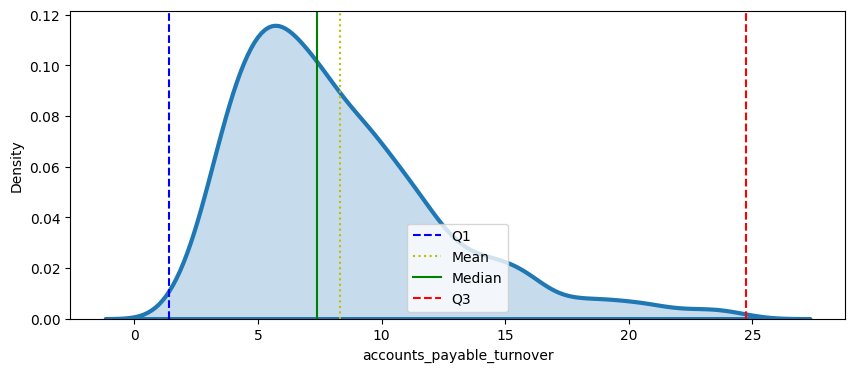

In [23]:
credit_data_null = ['ebitda_to_interest_expense', 'market_capitalization']

investment_data_null = ['interest_coverage_ratio', 'earnings_per_share', 'book_value_per_share', 'price_earnings_ratio',
             'price_to_book_ratio', 'price_cash_flow_ratio', 'enterprise_value_to_ebitda',
             'accounts_receivable_turnover', 'inventory_turnover', 'accounts_payable_turnover']

print("NULL DATA FOR CREDIT_DATA", end="\n\n\n")

for account in credit_data_null: 
    print(account, end="\n\n") 

    plt.figure(figsize=(10, 4))
    account_data = credit_data[account].dropna() 
    Q1 = account_data.quantile(0.05)
    Q3 = account_data.quantile(0.95)
    IQR = account_data[(account_data >= Q1) & (account_data <= Q3)]
    
    print(account_data.describe())

    sns.kdeplot(IQR, fill=True, linewidth=3)

    plt.axvline(Q1, color='b', linestyle='--', label='Q1')
    plt.axvline(np.mean(IQR), color='y', linestyle=':', label='Mean')
    plt.axvline(np.median(IQR), color='g', linestyle='-', label='Median')
    plt.axvline(Q3, color='r', linestyle='--', label='Q3')

    plt.title('Density Plot for '+account + ' (IQR only)')
    plt.xlabel(account)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

print("NULL DATA FOR INVESTMENT_DATA", end="\n\n\n")

for account in investment_data_null: 
    print(account, end="\n\n") 

    plt.figure(figsize=(10, 4))
    account_data = investment_data[account].dropna() 
    Q1 = account_data.quantile(0.05)
    Q3 = account_data.quantile(0.95)
    IQR = account_data[(account_data >= Q1) & (account_data <= Q3)]
    
    print(account_data.describe())

    sns.kdeplot(IQR, fill=True, linewidth=3)
    
    plt.axvline(Q1, color='b', linestyle='--', label='Q1')
    plt.axvline(np.mean(IQR), color='y', linestyle=':', label='Mean')
    plt.axvline(np.median(IQR), color='g', linestyle='-', label='Median')
    plt.axvline(Q3, color='r', linestyle='--', label='Q3')

    plt.xlabel(account)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

### final_features 결측치 제거 

#### outstanding_shares

In [24]:
null_outstanding_shares = data[data['outstanding_shares']==0][['corp', 'year']]

fill_outstanding_shares = [18000000, 21390000, 21390000, 5800000, 5800000, 6082642,
                           6082642, 6082642, 6082642, 6082642, 6500, 6500, 17000,
                           35000, 35000, 28000, 28000, 6000, 15100, 15100, 49000,
                           49000, 28144832, 28144832, 28144832, 28144832, 28144832,
                           90000, 90000, 135000, 135000, 13700, 13700, 12250,
                           23402441, 23402441, 23402441, 23402441, 23402441]

for (index, row), fill_value in zip(null_outstanding_shares.iterrows(), fill_outstanding_shares):
    corp, year = row['corp'], row['year']
    data.loc[(data['corp'] == corp) & (data['year'] == year), 'outstanding_shares'] = fill_value

#### stock_price
1. 최근 결측치 공모가로 데이터 채워넣기 
2. 결측치가 더 많으면 계산: <b>해당년도 주가 = (해당년도 매출액 / (해당년도+1) 매출액) * (해당년도+1) 주가</b>

In [25]:
null_stock_price_corp = data[data['stock_price'].isna()]['corp'].unique().tolist()
null_stock_price_corp.append('지누스')

stock_price_fill_years = ['2020', '2021', '2020', '2020', '2019', '2018', '2020', '2019', '2020', '2021', '2021', '2018', '2020', '2019', '2019', '2020', '2020', '2019', '2020', '2018', '2018', '2018']

fill_stock_price = [
    60000, 300000, 65000, 105000, 12300, 13000, 59000, 6500, 17000, 35000, 28000, 6000, 15100, 49000, 7500, 90000, 498000, 135000, 13700, 12250, 48000, 70000
]

for corp, year, price in zip(null_stock_price_corp, stock_price_fill_years, fill_stock_price):
    data.loc[(data['corp'] == corp) & (data['year'] == year), 'stock_price'] = price

In [26]:
data = data.sort_values(by='year', ascending=False)

for index, row in data.iterrows():
    if pd.isna(row['stock_price']):
        corp = row['corp']
        year = int(row['year'])

        if ((data['corp'] == corp) & (data['year'] == str(year+1))).any():
            next_year_row = data[(data['corp'] == corp) & (data['year'] == str(year+1))].iloc[0]

            new_price = (row['revenue'] / next_year_row['revenue']) * next_year_row['stock_price']
            
            data.at[index, 'stock_price'] = new_price
    
data = data.sort_values(['corp', 'year'])

### market_capitalization

In [27]:
if data['market_capitalization'].isna().any(): 
    data['market_capitalization'] = data['market_capitalization'].fillna(data['stock_price'] * data['outstanding_shares'])

### interest

In [28]:
data = data[data['interest'] != 0]

### Credit Data

In [29]:
credit_data = data[["corp", "stock_code", "sector", "year"]].copy()

data.loc[:, "net_borrowings"] = data["borrowings"] - data["cash_and_equivalents"]
data.loc[:, "quick_assets"] = data["current_assets"] - data["inventory"]

credit_data.loc[:, "ebitda_margin"] = data["ebitda"] / data["revenue"] * 100
credit_data.loc[:, "ebitda_to_interest_expense"] = data["ebitda"] / data["interest"]
credit_data.loc[:, "debt_ratio"] = data["total_liabilities"] / data["total_assets"]
credit_data.loc[:, "dependence_on_net_borrowings"] = (
    data["borrowings"] / data["total_equity"]
)

credit_data.loc[:, "net_borrowings_to_ebitda"] = data["net_borrowings"] / data["ebitda"]
credit_data.loc[:, "sales_revenue"] = data["revenue"]
credit_data.loc[:, "cogs"] = data["cost_of_sales"]
credit_data.loc[:, "selling_general_administrative_expenses"] = data[
    "selling_general_administrative_expenses"
]
credit_data.loc[:, "ebit"] = data["ebit"]
credit_data.loc[:, "ebit_margin"] = data["ebit"] / data["revenue"] * 100
credit_data.loc[:, "ebitda_to_sales_revenue"] = data["ebitda"] / data["revenue"]
credit_data.loc[:, "total_assets"] = data["total_assets"]
credit_data.loc[:, "roa"] = data["net_income"] / data["total_assets"] * 100
credit_data.loc[:, "ebitda"] = data["ebitda"]
credit_data.loc[:, "financial_expenses"] = data["interest"]
credit_data.loc[:, "corporate_tax"] = data["tax"]
credit_data.loc[:, "operating_cash_flow"] = data["cash_flow_operating"]
credit_data.loc[:, "free_cash_flow"] = (
    data["cash_flow_operating"] - data["cash_flow_investing"]
)
credit_data.loc[:, "total_liabilities"] = data["total_liabilities"]
credit_data.loc[:, "total_equity"] = data["total_equity"]
credit_data.loc[:, "total_borrowings"] = data["borrowings"]
credit_data.loc[:, "net_borrowings"] = data["net_borrowings"]
credit_data.loc[:, "borrowing_dependency"] = data["borrowings"] / data["total_equity"]
credit_data.loc[:, "total_borrowings_to_ebitda"] = data["borrowings"] / data["ebitda"]
credit_data.loc[:, "debt_to_net_income_ratio"] = (
    data["total_liabilities"] / data["net_income"]
)
credit_data.loc[:, "total_assets_leverage"] = (
    data["total_assets"] / data["total_equity"]
)
credit_data.loc[:, "current_liabilities"] = data["current_liabilities"]
credit_data.loc[:, "working_capital"] = (
    data["current_assets"] - data["current_liabilities"]
)
credit_data.loc[:, "current_liabilities_ratio"] = (
    data["current_liabilities"] / data["current_assets"]
)
credit_data.loc[:, "quick_assets"] = data["quick_assets"]
credit_data.loc[:, "quick_ratio"] = data["quick_assets"] / data["current_liabilities"]
credit_data.loc[:, "cash_and_cash_equivalents"] = data["cash_and_equivalents"]
credit_data.loc[:, "short_term_borrowings"] = data["short_borrowing"]
credit_data.loc[:, "days_sales_outstanding"] = (
    data["accounts_receivable"] / data["revenue"] * 365
)
credit_data.loc[:, "average_accounts_receivable_per_sales_turnover"] = (
    data["accounts_receivable"] / data["revenue"]
)
credit_data.loc[:, "market_capitalization"] = data["market_capitalization"]

credit_data = credit_data.replace([np.inf, -np.inf], np.nan)

### Investment Data

In [30]:
investment_data = data[["corp", "stock_code", "sector", "year"]].copy()

data["earnings_per_share"] = data["net_income"] / data["outstanding_shares"]
data["book_value_per_share"] = data["total_equity"] / data["outstanding_shares"]


# 수익성 (Profitability)
investment_data["gross_profit_margin"] = (data["gross_profit"] / data["revenue"]) * 100
investment_data["operating_profit_margin"] = (
    data["operating_income"] / data["revenue"]
) * 100
investment_data["net_profit_margin"] = (data["net_income"] / data["revenue"]) * 100
investment_data["ebitda_margin"] = (data["ebitda"] / data["revenue"]) * 100
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["return_on_assets"] = (data["net_income"] / data["total_assets"]) * 100
investment_data["return_on_invested_capital"] = data["operating_income"] / (
    data["total_equity"] + data["total_liabilities"]
)

# 안정성 (Stability)
investment_data["debt_ratio"] = data["total_liabilities"] / data["total_assets"]
investment_data["current_ratio"] = data["current_assets"] / data["current_liabilities"]
investment_data["quick_ratio"] = (data["current_assets"] - data["inventory"]) / data[
    "current_liabilities"
]
investment_data["non_current_debt_ratio"] = (
    data["non_current_liabilities"] / data["total_assets"]
)
investment_data["equity_ratio"] = data["total_equity"] / data["total_assets"]
investment_data["interest_coverage_ratio"] = data["ebit"] / data["interest"]
investment_data["debt_to_equity_ratio"] = (
    data["total_liabilities"] / data["total_equity"]
)
investment_data["net_debt_ratio"] = (
    data["borrowings"] - data["cash_and_equivalents"]
) / data["total_assets"]
investment_data["retention_ratio"] = data["retained_earnings"] / data["net_income"]


# 가치지표 (Valuation Ratios)
investment_data["earnings_per_share"] = data["net_income"] / data["outstanding_shares"]
investment_data["book_value_per_share"] = (
    data["total_equity"] / data["outstanding_shares"]
)
investment_data["price_earnings_ratio"] = (
    data["stock_price"] / data["earnings_per_share"]
)
investment_data["price_to_book_ratio"] = (
    data["stock_price"] / data["book_value_per_share"]
)
investment_data["price_cash_flow_ratio"] = data["stock_price"] / (
    data["cash_flow_operating"] / data["outstanding_shares"]
)
investment_data["enterprise_value_to_ebitda"] = (
    data["market_capitalization"] + data["borrowings"] - data["cash_and_equivalents"]
) / data["ebitda"]

investment_data["market_capitalization"] = data["market_capitalization"]


# 성장성 (Growth): 성장성 대신 성장성에 해당하는 계정 넣어도 성장성이 반영 됨 
investment_data['revenue'] = data['revenue']
investment_data['operating_income'] = data['operating_income']
investment_data['net_income'] = data['net_income']
investment_data['total_assets'] = data['total_assets']
investment_data['fixed_assets'] = data['fixed_assets']
investment_data['total_liabilities'] = data['total_liabilities']
investment_data['total_equity'] = data['total_equity']


# 활동성 (Efficiency)
investment_data["total_asset_turnover"] = data["revenue"] / data["total_assets"]
investment_data["return_on_equity"] = (data["net_income"] / data["total_equity"]) * 100
investment_data["net_working_capital_turnover"] = data["revenue"] / (
    data["current_assets"] - data["current_liabilities"]
)
investment_data["fixed_asset_turnover"] = data["revenue"] / data["fixed_assets"]
investment_data["accounts_receivable_turnover"] = (
    data["revenue"] / data["accounts_receivable"]
)
investment_data["inventory_turnover"] = data["cost_of_sales"] / data["inventory"]
investment_data["accounts_payable_turnover"] = (
    data["cost_of_sales"] / data["accounts_payable"]
)

investment_data = investment_data.replace([np.inf, -np.inf], np.nan)

### 'accounts_receivable_turnover', 'inventory_turnover', 'accounts_payable_turnover' NULL값 0으로 대체
- 중앙값이 비교적으로 낮아서 (6, 5, 7) 0값 으로 대체


In [31]:
investment_data['accounts_receivable_turnover'] = investment_data['accounts_receivable_turnover'].fillna(0)
investment_data['inventory_turnover'] = investment_data['inventory_turnover'].fillna(0)
investment_data['accounts_payable_turnover'] = investment_data['accounts_payable_turnover'].fillna(0)

### 결측치 처리 확인!

In [32]:
print(credit_data.isna().sum().sum())
print(investment_data.isna().sum().sum())

0
0


### CSV 저장 / MySQL 적제 

In [33]:
credit_data.to_csv('credit_data_model.csv', encoding='utf-8-sig', index=False)
investment_data.to_csv('investment_data_model.csv', encoding='utf-8-sig', index=False)

In [34]:
data_tables = {
    "credit_data_model": credit_data,
    "investment_data_model": investment_data
}

engine = create_engine(
    f"mysql+pymysql://{username}:{password}@{hostname}/{database_name}"
)
Session = sessionmaker(bind=engine)

for table_name, df in data_tables.items():
    try:
        with engine.begin() as connection, Session() as session:
            df.to_sql(
                table_name,
                con=connection,
                if_exists="replace",
                index=False,
                chunksize=1000,
            )
            session.commit()
    except Exception as e:
        print(f"An error occurred while processing {table_name}: {str(e)}")
        session.rollback()